In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
%pip install konlpy

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
from sklearn.datasets import load_files
import pandas as pd
from bs4 import BeautifulSoup
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
import pickle
import re
from konlpy.tag import Okt
import nltk
import numpy as np


In [ ]:
%cd '/content/drive/MyDrive/newsData'

/content/drive/MyDrive/newsData


In [ ]:
df = pd.read_csv('news_clean_kss.csv', index_col=0, names=['content'])

In [ ]:
df

,content
NaN,0
0.0,태양광으로 충전되는 ‘아이폰X 테슬라’\t(지디넷코리아=이정현 기자)도널드 트럼프 ...
1.0,돈 꽃다발' '돈 케이크'…현금 선호 뚜렷한 어버이날 선물 새 풍경\t[앵커]\n어...
2.0,"[월드 스누커] 이대규, 유망주 왕즈펑 꺾고 3라운드 진출\t[엠스플뉴스]\n \n..."
3.0,냉랭한 멜라니아 … 트럼프와 각방 쓰고 휴일에도 따로\t트럼프 불륜설 뒤 일정 부쩍...
...,...
1570.0,“한예슬 의료사고는 전형적인 ‘VIP 신드롬’ 때문”\t배우 한예슬이 지방종 제거 ...
1571.0,中 쓰레기장에서 '고기' 캐는 주민들\t[앵커]\n중국 윈난성의 한 농촌에서는 일주...
1572.0,[종합] '시크릿 마더' 김소연 누가 죽였나…송윤아와 갈등\t[엑스포츠뉴스 이이진 ...
1573.0,"근로자의날 휴무, 은행은 쉬지만 택배는 받는다…공무원들은?\t근로자의 날이 하루 앞..."


In [ ]:
new_df = pd.DataFrame(columns=['content'])

# 기존 DataFrame의 각 행에 대해 반복
for row in df.itertuples():
    # 문자열을 \t와 \n으로 분리
    text_list = row.content.split('\t')
    
    for lst in text_list:
      sentences = lst.split('\n')
        
      for lines in sentences:
        line = lines.split('.')
    
        # 분리된 각 문장에 대해 새로운 DataFrame에 추가
        for text in line:
          new_df = pd.concat([new_df, pd.DataFrame({'content': text}, index=[len(new_df)])], ignore_index=True)

# 결과 출력
print(new_df)

                                                 content
0                                                      0
1                                  태양광으로 충전되는 ‘아이폰X 테슬라’
2      (지디넷코리아=이정현 기자)도널드 트럼프 미국 대통령과 푸틴 러시아 대통령의 초상화...
3                                                       
4                                                       
...                                                  ...
60800                   연구팀은 이후 6개월을 더 지켜봤지만, 결과는 마찬가지였다
60801                                                   
60802                                                   
60803  이 연구결과는 미국 임상 영양학 저널(American Journal of Clini...
60804                                                   

[60805 rows x 1 columns]


In [ ]:
new_df

,content
0,0
1,태양광으로 충전되는 ‘아이폰X 테슬라’
2,(지디넷코리아=이정현 기자)도널드 트럼프 미국 대통령과 푸틴 러시아 대통령의 초상화...
3,
4,
...,...
60800,"연구팀은 이후 6개월을 더 지켜봤지만, 결과는 마찬가지였다"
60801,
60802,
60803,이 연구결과는 미국 임상 영양학 저널(American Journal of Clini...


In [ ]:
new_df = new_df.replace('', pd.np.nan).dropna(axis=0)
new_df = new_df.reset_index(drop=True)

<ipython-input-211-e195551376fa>:1: FutureWarning: The pandas.np module is deprecated and will be removed from pandas in a future version. Import numpy directly instead.
  new_df = new_df.replace('', pd.np.nan).dropna(axis=0)


In [ ]:
new_df.content[3]

'이 업체는 주로 아이폰, 애플워치 등의\xa0IT\xa0제품들을 금으로 장식하고 개조해 고가에 판매하는 업체다'

In [ ]:
def remove_nbsp(text):
    return text.replace('\xa0', ' ')

# apply() 메서드를 사용하여 content 열의 모든 행에 대해 remove_nbsp 함수를 적용하고, 결과를 'content' 열에 덮어쓰기
new_df['content'] = new_df['content'].apply(remove_nbsp)

# 수정된 데이터프레임 출력
print(new_df)

                                                 content
0                                                      0
1                                  태양광으로 충전되는 ‘아이폰X 테슬라’
2      (지디넷코리아=이정현 기자)도널드 트럼프 미국 대통령과 푸틴 러시아 대통령의 초상화...
3      이 업체는 주로 아이폰, 애플워치 등의 IT 제품들을 금으로 장식하고 개조해 고가에...
4                           이 아이폰의 이름은 ‘아이폰X 테슬라(Tesla)’
...                                                  ...
34555                                                   
34556              결과는 마찬가지로 두 그룹 모두 심혈관 건강 표지가 나빠지지 않았다
34557                      이와 함께 두 그룹이 다 같이 체중도 비슷하게 빠졌다
34558                   연구팀은 이후 6개월을 더 지켜봤지만, 결과는 마찬가지였다
34559  이 연구결과는 미국 임상 영양학 저널(American Journal of Clini...

[34560 rows x 1 columns]


In [ ]:
okt = Okt()
sentences = okt.pos('안녕하세요. 반갑습니다. KoNLPy를 사용해봅시다.')
print(sentences)

[('안녕하세요', 'Adjective'), ('.', 'Punctuation'), ('반갑습니다', 'Adjective'), ('.', 'Punctuation'), ('KoNLPy', 'Alpha'), ('를', 'Noun'), ('사용', 'Noun'), ('해봅시다', 'Verb'), ('.', 'Punctuation')]


In [ ]:
cnt = 0
ndf = pd.DataFrame(columns=['content'])

from konlpy.tag import Okt

okt = Okt()

for sentence in new_df['content']:
    temp_sentence = ''
    pos_all = okt.pos(sentence)
    for pos in pos_all:
        # print(pos)
        if pos and (pos[1] == 'Noun' or pos[1] == 'Verb' or pos[1] == 'Adjective' or pos[1] == 'Adverb'):
            temp_sentence += pos[0]
            temp_sentence += ' '
        
    if temp_sentence:
        ndf.loc[cnt] = [temp_sentence]
        cnt += 1
    
    if cnt % 10000 == 0:
        print(temp_sentence, cnt)
    if cnt % 50000 == 0:
        ndf.to_csv(f'ndf_{cnt}.csv', index=False)


# # 마지막에 남은 문장 저장
# if temp_sentence:
#     ndf.loc[cnt] = [temp_sentence]
#     cnt += 1
#     temp_sentence = ''

# 마지막으로 생성된 ndf 저장
ndf.to_csv(f'ndf_{cnt}.csv', index=False)

print(sentences)


 0
식도 담당 하는 감각 신경 왼쪽 어깨 앞 부분 연결 돼있기 때문  10000
카 드림 장 정혁 라이트급 매치 패 뒤 체급 전향 했다  20000
한국 발사체 발사 앞두고  30000
[('안녕하세요', 'Adjective'), ('.', 'Punctuation'), ('반갑습니다', 'Adjective'), ('.', 'Punctuation'), ('KoNLPy', 'Alpha'), ('를', 'Noun'), ('사용', 'Noun'), ('해봅시다', 'Verb'), ('.', 'Punctuation')]


In [ ]:
# !jupyter notebook --NotebookApp.iopub_data_rate_limit=10000000


In [ ]:
print(new_df.content)
print(ndf.content)

0                                                        0
1                                    태양광으로 충전되는 ‘아이폰X 테슬라’
2        (지디넷코리아=이정현 기자)도널드 트럼프 미국 대통령과 푸틴 러시아 대통령의 초상화...
3        이 업체는 주로 아이폰, 애플워치 등의 IT 제품들을 금으로 장식하고 개조해 고가에...
4                             이 아이폰의 이름은 ‘아이폰X 테슬라(Tesla)’
                               ...                        
34555                                                     
34556                결과는 마찬가지로 두 그룹 모두 심혈관 건강 표지가 나빠지지 않았다
34557                        이와 함께 두 그룹이 다 같이 체중도 비슷하게 빠졌다
34558                     연구팀은 이후 6개월을 더 지켜봤지만, 결과는 마찬가지였다
34559    이 연구결과는 미국 임상 영양학 저널(American Journal of Clini...
Name: content, Length: 34560, dtype: object
0                                       태양광 충전 되는 아이폰 테슬라 
1        지디 넷 코리아 이정현 기자 도널드 트럼프 미국 대통령 푸틴 러시아 대통령 초상화 ...
2            이 업체 주로 아이폰 애플 워치 등 제품 금 장식 개조 해 고가 판매 하는 업체 
3                                        이 아이폰 이름 아이폰 테슬라 
4        이 제품 면 태양 전지 패널 있어 스마트폰 뒤집어 놓기만 하면 충전 되어 보조 배터...
            

In [ ]:
result = ndf.copy()

In [ ]:
# 데이터 중복을 제외한 갯수 확인
print(result['content'].nunique())
# print(result.duplicated('content'))
# 중복 데이터 제거
result = result.drop_duplicates(['content'], keep= 'first')

print(result)
# 데이터셋 갯수 확인
# print('중복 제거 후 데이터셋 : {}'.format(len(result)))

29204
                                                 content
0                                     태양광 충전 되는 아이폰 테슬라 
1      지디 넷 코리아 이정현 기자 도널드 트럼프 미국 대통령 푸틴 러시아 대통령 초상화 ...
2          이 업체 주로 아이폰 애플 워치 등 제품 금 장식 개조 해 고가 판매 하는 업체 
3                                      이 아이폰 이름 아이폰 테슬라 
4      이 제품 면 태양 전지 패널 있어 스마트폰 뒤집어 놓기만 하면 충전 되어 보조 배터...
...                                                  ...
30231  팀 이어 두 그룹 계란 섭취량 그대로 유지 하면서 이번 개월 동안 체중 감량 다이어...
30232               결과 마찬가지 두 그룹 모두 심 혈관 건강 표지 나빠지지 않았다 
30233                        이 함께 두 그룹 다 같이 체중 비슷하게 빠졌다 
30234                        팀 이후 개월 더 지켜봤지만 결과 마찬가지 였다 
30235                            이 구결 미국 임 영양학 널 최신 실렸다 

[29204 rows x 1 columns]


In [ ]:
import numpy as np

# null 데이터 제거
result['content'].replace('', np.nan, inplace=True)
result = result.dropna(how = 'any')

print('null 제거 후 테스트 데이터셋 : {}'.format(len(result)))

null 제거 후 테스트 데이터셋 : 29204


<ipython-input-220-6c5ba367babd>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  result['content'].replace('', np.nan, inplace=True)


학습 문장 최대 길이 : 304
학습 문장의 평균 길이 : 46.59235036296398


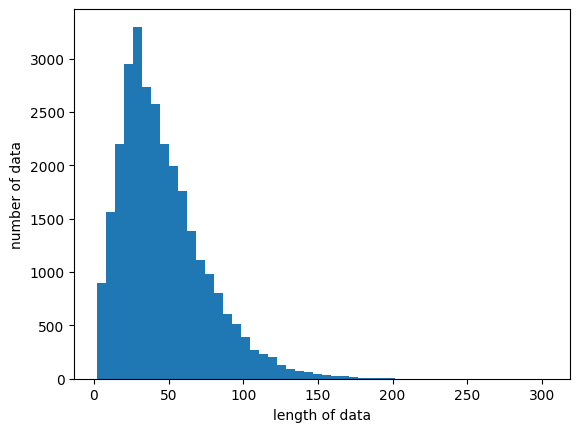

In [ ]:
from matplotlib import pyplot as plt

#학습 리뷰 길이조사
print('학습 문장 최대 길이 :',max(len(l) for l in result['content']))
print('학습 문장의 평균 길이 :',sum(map(len, result['content']))/len(result['content']))

plt.hist([len(s) for s in result['content']], bins=50)
plt.xlabel('length of data')
plt.ylabel('number of data')
plt.show()

In [ ]:
def clean(docs):
    # html 태그 제거
    for i, doc in enumerate(docs):
        doc = BeautifulSoup(doc, 'html.parser').text
        docs[i] = doc

    # 텍스트 정제 (특수기호 제거)
    for i, doc in enumerate(docs):
        doc = re.sub(r'[^ ㄱ-ㅣ가-힣]', '', doc) #특수기호 제거, 정규 표현식
        docs[i] = doc

    return docs


In [ ]:
# https://blog.naver.com/PostView.nhn?blogId=wideeyed&logNo=221337575742
# kkma는 처리 시간이 길어 길고 다량의 문장을 처리하기에 부적합하다고 판단
# komoran < hannanum < okt에 대해서만 형태소 분석 테스트를 진행함

def morph_okt(docs):
    #텍스트 정제 (형태소 분석)
    lst = []
    for i, doc in enumerate(docs):
        okt = Okt()
        clean_words = []
        for word in okt.pos(doc): 
          # 어간 추출 및 정규화 가능하지만 다른 형태소분석기와 조건을 동일하게 진행하기 위해 
          # 사전에 표제어 추출을 진행한 후 품사태깅을 진행하고싶었는데 한국어는 표제어추출할수가 없는거같은디
          # okt로 표제어만 먼저 추출하고 돌리면 됨
            if word[1] in ['Noun', 'Verb', 'Adjective']: #명사, 동사, 형용사
                clean_words.append(word[0])
        # doc = ' '.join(clean_words)
        # docs[i] = doc
        lst.append(clean_words)
    return lst # docs
  

In [ ]:
result['content'] = clean(result['content']) #텍스트 정제

In [ ]:
result

,content
0,태양광 충전 되는 아이폰 테슬라
1,지디 넷 코리아 이정현 기자 도널드 트럼프 미국 대통령 푸틴 러시아 대통령 초상화 ...
2,이 업체 주로 아이폰 애플 워치 등 제품 금 장식 개조 해 고가 판매 하는 업체
3,이 아이폰 이름 아이폰 테슬라
4,이 제품 면 태양 전지 패널 있어 스마트폰 뒤집어 놓기만 하면 충전 되어 보조 배터...
...,...
30231,팀 이어 두 그룹 계란 섭취량 그대로 유지 하면서 이번 개월 동안 체중 감량 다이어...
30232,결과 마찬가지 두 그룹 모두 심 혈관 건강 표지 나빠지지 않았다
30233,이 함께 두 그룹 다 같이 체중 비슷하게 빠졌다
30234,팀 이후 개월 더 지켜봤지만 결과 마찬가지 였다


In [ ]:
# okt 형태소 분석
okt_data = morph_okt(result['content'])
okt_data = result['content']
okt_data

0                                       태양광 충전 되는 아이폰 테슬라 
1        지디 넷 코리아 이정현 기자 도널드 트럼프 미국 대통령 푸틴 러시아 대통령 초상화 ...
2            이 업체 주로 아이폰 애플 워치 등 제품 금 장식 개조 해 고가 판매 하는 업체 
3                                        이 아이폰 이름 아이폰 테슬라 
4        이 제품 면 태양 전지 패널 있어 스마트폰 뒤집어 놓기만 하면 충전 되어 보조 배터...
                               ...                        
30231    팀 이어 두 그룹 계란 섭취량 그대로 유지 하면서 이번 개월 동안 체중 감량 다이어...
30232                 결과 마찬가지 두 그룹 모두 심 혈관 건강 표지 나빠지지 않았다 
30233                          이 함께 두 그룹 다 같이 체중 비슷하게 빠졌다 
30234                          팀 이후 개월 더 지켜봤지만 결과 마찬가지 였다 
30235                              이 구결 미국 임 영양학 널 최신 실렸다 
Name: content, Length: 29204, dtype: object

In [ ]:
before_stopwords = pd.DataFrame({'content': okt_data})
len(okt_data)

29204

In [ ]:
before_stopwords.to_csv(f'okt_data_before_stopwords_list.csv', index=False)

In [ ]:
before_stopwords

,content
0,태양광 충전 되는 아이폰 테슬라
1,지디 넷 코리아 이정현 기자 도널드 트럼프 미국 대통령 푸틴 러시아 대통령 초상화 ...
2,이 업체 주로 아이폰 애플 워치 등 제품 금 장식 개조 해 고가 판매 하는 업체
3,이 아이폰 이름 아이폰 테슬라
4,이 제품 면 태양 전지 패널 있어 스마트폰 뒤집어 놓기만 하면 충전 되어 보조 배터...
...,...
30231,팀 이어 두 그룹 계란 섭취량 그대로 유지 하면서 이번 개월 동안 체중 감량 다이어...
30232,결과 마찬가지 두 그룹 모두 심 혈관 건강 표지 나빠지지 않았다
30233,이 함께 두 그룹 다 같이 체중 비슷하게 빠졌다
30234,팀 이후 개월 더 지켜봤지만 결과 마찬가지 였다


In [ ]:
okt_data

0                                       태양광 충전 되는 아이폰 테슬라 
1        지디 넷 코리아 이정현 기자 도널드 트럼프 미국 대통령 푸틴 러시아 대통령 초상화 ...
2            이 업체 주로 아이폰 애플 워치 등 제품 금 장식 개조 해 고가 판매 하는 업체 
3                                        이 아이폰 이름 아이폰 테슬라 
4        이 제품 면 태양 전지 패널 있어 스마트폰 뒤집어 놓기만 하면 충전 되어 보조 배터...
                               ...                        
30231    팀 이어 두 그룹 계란 섭취량 그대로 유지 하면서 이번 개월 동안 체중 감량 다이어...
30232                 결과 마찬가지 두 그룹 모두 심 혈관 건강 표지 나빠지지 않았다 
30233                          이 함께 두 그룹 다 같이 체중 비슷하게 빠졌다 
30234                          팀 이후 개월 더 지켜봤지만 결과 마찬가지 였다 
30235                              이 구결 미국 임 영양학 널 최신 실렸다 
Name: content, Length: 29204, dtype: object

In [ ]:
def stopwords(docs):
    #텍스트 정제 (불용어 제거)
    st = pd.read_csv('https://raw.githubusercontent.com/cranberryai/todak_todak_python/master/machine_learning_text/clean_korean_documents/korean_stopwords.txt', header=None)
    st[0] = st[0].apply(lambda x: x.strip())
    stopwords = st[0].to_numpy()
    nltk.download('punkt')
    for i, doc in enumerate(docs):
        clean_words = [] 
        for word in doc.split(): 
            print(" : " ,word)
            if len(word)>1 and word not in stopwords: #불용어 제거
                clean_words.append(word)
        docs[i] = clean_words

    return docs
  
okt_data_end = stopwords(okt_data) 


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


스트리밍 출력 내용이 길어서 마지막 5000줄이 삭제되었습니다.
 :  채용
 :  비리
 :  검사
 :  추가
 :  확대
 :  할
 :  움직임
 :  보이지
 :  않는
 :  데
 :  채용
 :  비리
 :  소지
 :  최소
 :  은행권
 :  채용
 :  모범
 :  규준
 :  윤곽
 :  잡아가는
 :  것
 :  채용
 :  시작
 :  되는
 :  배경
 :  서울특별시
 :  버스
 :  운송
 :  사업
 :  조합
 :  온라인
 :  사이트
 :  음식물
 :  반입
 :  불쾌함을
 :  느꼈다며
 :  민원
 :  제기
 :  하는
 :  게시
 :  글
 :  꾸준히
 :  올라오고
 :  있다
 :  승객
 :  버스
 :  기다리기
 :  위해
 :  앉는
 :  공간
 :  버려진
 :  일회용
 :  컵
 :  차지
 :  했다
 :  한
 :  환경미화원
 :  서울시
 :  정류장
 :  쓰레기통
 :  새로
 :  설치
 :  해
 :  줬으면
 :  좋겠지만
 :  생활
 :  쓰레기
 :  무단
 :  버리는
 :  이
 :  많아
 :  쉽지
 :  않은
 :  상황
 :  들었다
 :  며
 :  고충
 :  토로
 :  했다
 :  풍
 :  계리
 :  폐쇄
 :  폄하하는
 :  보도
 :  잇따른다
 :  박
 :  양
 :  친구
 :  중
 :  명품
 :  가방
 :  그림
 :  그려
 :  드리겠다는
 :  경우
 :  있다
 :  지난해
 :  정말
 :  것
 :  안
 :  해도
 :  되는
 :  것
 :  우왕좌왕
 :  했던
 :  학부모
 :  올해
 :  한결
 :  마음
 :  편하다
 :  당장
 :  전
 :  할
 :  수
 :  없지만
 :  나중
 :  스승
 :  감사
 :  선물
 :  할
 :  수
 :  있는
 :  길은
 :  열려있다
 :  마이데일리
 :  이승
 :  길
 :  기자
 :  걸그룹
 :  마마
 :  무
 :  화사
 :  절친
 :

In [ ]:
okt_data_end

0                                  [태양광, 충전, 되는, 아이폰, 테슬라]
1        [지디, 코리아, 이정현, 기자, 도널드, 트럼프, 미국, 대통령, 푸틴, 러시아,...
2        [업체, 주로, 아이폰, 애플, 워치, 제품, 장식, 개조, 고가, 판매, 하는, 업체]
3                                      [아이폰, 이름, 아이폰, 테슬라]
4        [제품, 태양, 전지, 패널, 있어, 스마트폰, 뒤집어, 놓기만, 하면, 충전, 되...
                               ...                        
29095                                  [마이크론, 상승세, 점유, 상승]
29096    [지디, 코리아, 박영민, 기자, 글로벌, 시장, 점유, 기업인, 미국, 마이크론,...
29119                                        [유가, 보너스, 소멸]
29160                                        [하정완, 진짜, 마음]
29177                        [근로자의날, 휴무, 은행, 택배, 받는다, 공무원]
Name: content, Length: 30175, dtype: object

In [ ]:
# 글자 단위 10글자 이하 제거 - 10글자 미만의 텍스트는 단일 단어로 이뤄진 경우가 많아 해당 부분을 제외
# 일단 한글자인 문자만 제거
cnt = 0
temp = []
for i, data in enumerate(okt_data_end):
  for word in data:

    if len(word) >= 2:
      temp.append(word)
  
  if temp:
    okt_data_end[i] = temp
    temp = []


print(type(okt_data_end))

<class 'pandas.core.series.Series'>


In [ ]:
test = pd.DataFrame([okt_data_end])

test = test.transpose()
test

,content
0,"[태양광, 충전, 되는, 아이폰, 테슬라]"
1,"[지디, 코리아, 이정현, 기자, 도널드, 트럼프, 미국, 대통령, 푸틴, 러시아,..."
2,"[업체, 주로, 아이폰, 애플, 워치, 제품, 장식, 개조, 고가, 판매, 하는, 업체]"
3,"[아이폰, 이름, 아이폰, 테슬라]"
4,"[제품, 태양, 전지, 패널, 있어, 스마트폰, 뒤집어, 놓기만, 하면, 충전, 되..."
...,...
29969,"[가졌을, 종부세, 부과, 기준, 적용, 지난해, 종부세, 재산세, 유세, 냈다]"
30069,"[지난, 대진, 침대, 매트리스, 연간, 피폭, 선량]"
30093,"[지속, 가능한, 패션, 대한, 오랫동안, 지적, 됐다]"
30164,[넘었다]


In [ ]:
# test = test.replace(' ', np.nan).dropna(axis=0)
# test = test.reset_index(drop=True)

In [ ]:
# bool(test.content[30235])

In [ ]:
# test = test[test.astype(bool)]
# s = pd.Series(test['tokenized'].sum())
# s = s[s != '']


In [ ]:
!pip install --upgrade gensim==3.8.3
from gensim.models import word2vec
import matplotlib.pyplot as plt

# df.isnull().values.any()

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


문서 최대 길이 :  119
문서 평균 길이 :  11.969870353221326


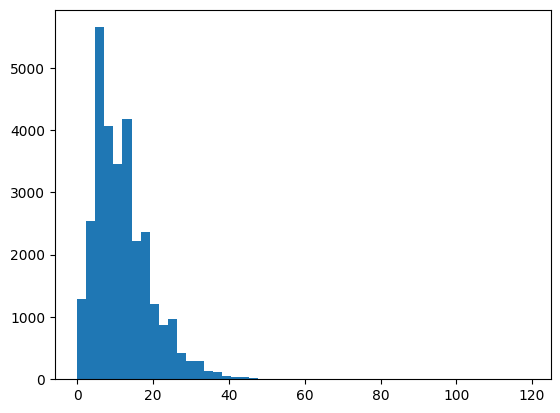

In [ ]:
print("문서 최대 길이 : ", max(len(d) for d in okt_data_end))
print("문서 평균 길이 : ", sum(map(len, okt_data_end))/len(okt_data_end))

plt.hist([len(d) for d in okt_data_end], bins=50)
plt.show()

In [ ]:
okt_data_end

0                                  [태양광, 충전, 되는, 아이폰, 테슬라]
1        [지디, 코리아, 이정현, 기자, 도널드, 트럼프, 미국, 대통령, 푸틴, 러시아,...
2        [업체, 주로, 아이폰, 애플, 워치, 제품, 장식, 개조, 고가, 판매, 하는, 업체]
3                                      [아이폰, 이름, 아이폰, 테슬라]
4        [제품, 태양, 전지, 패널, 있어, 스마트폰, 뒤집어, 놓기만, 하면, 충전, 되...
                               ...                        
29969        [가졌을, 종부세, 부과, 기준, 적용, 지난해, 종부세, 재산세, 유세, 냈다]
30069                       [지난, 대진, 침대, 매트리스, 연간, 피폭, 선량]
30093                      [지속, 가능한, 패션, 대한, 오랫동안, 지적, 됐다]
30164                                                [넘었다]
30168                         [대학원생, 옥희, 가명, 비슷한, 견해, 밝혔다]
Name: content, Length: 30236, dtype: object

In [ ]:
o = pd.DataFrame({'content': okt_data_end})

In [ ]:
o

,content
0,"[태양광, 충전, 되는, 아이폰, 테슬라]"
1,"[지디, 코리아, 이정현, 기자, 도널드, 트럼프, 미국, 대통령, 푸틴, 러시아,..."
2,"[업체, 주로, 아이폰, 애플, 워치, 제품, 장식, 개조, 고가, 판매, 하는, 업체]"
3,"[아이폰, 이름, 아이폰, 테슬라]"
4,"[제품, 태양, 전지, 패널, 있어, 스마트폰, 뒤집어, 놓기만, 하면, 충전, 되..."
...,...
29969,"[가졌을, 종부세, 부과, 기준, 적용, 지난해, 종부세, 재산세, 유세, 냈다]"
30069,"[지난, 대진, 침대, 매트리스, 연간, 피폭, 선량]"
30093,"[지속, 가능한, 패션, 대한, 오랫동안, 지적, 됐다]"
30164,[넘었다]


In [ ]:
o.to_csv(f'okt_data_end.csv', index=False)

In [ ]:
# word2vec 모델 학습에 로그를 찍을 수 있도록 합니다.
import logging
logging.basicConfig(
    format='%(asctime)s : %(levelname)s : %(message)s', 
    level=logging.INFO)

In [ ]:
from gensim.models import Word2Vec

def wv(docs):
    model = Word2Vec(window=5, min_count=10, workers=4)
    model.build_vocab(docs)
    model.train(sentences=docs, total_examples=model.corpus_count, epochs=model.epochs)
    word_vectors = model.wv
    return word_vectors

word_vectors = wv(okt_data_end)

In [ ]:
word_vectors.wv['했다']

<ipython-input-246-b6db15000f75>:1: DeprecationWarning: Call to deprecated `wv` (Attribute will be removed in 4.0.0, use self instead).
  word_vectors.wv['했다']


array([ 0.44440034, -0.03336902, -0.08632848, -0.4837106 , -0.79405856,
       -0.44462997, -0.30009824, -0.3420941 , -0.14685133, -0.88742685,
       -0.16372214, -0.43463683,  0.21062286,  0.16331585,  0.4984189 ,
        0.14536247, -0.63801014, -0.5731896 ,  0.59576637,  0.905582  ,
       -0.04074607,  0.2854171 , -0.60212314,  0.17567793,  0.33536905,
       -0.7352609 ,  0.39532474, -0.51199174,  0.30766737, -0.28620353,
       -0.08926   , -0.22378469, -0.05486123, -0.51681864,  0.524809  ,
        0.15689915,  0.2450253 ,  0.01398382,  0.2038836 ,  0.13251145,
       -0.49978676,  0.26987845,  0.09891436,  0.03151499, -0.77753866,
       -0.503633  , -0.2686561 ,  0.57729125, -0.87380457,  0.8113126 ,
       -0.46682668, -0.5046236 ,  0.2611381 ,  0.09750807, -0.03263166,
        0.5595564 ,  0.16193506,  0.09760158,  0.3696455 , -0.5638978 ,
       -0.6483959 ,  0.22497857,  0.6093397 , -0.2172682 , -0.11826244,
        0.76332223, -0.4676595 , -0.6894082 ,  0.03749706,  0.14

In [ ]:
vocab = word_vectors.wv

<ipython-input-247-d41282862d31>:1: DeprecationWarning: Call to deprecated `wv` (Attribute will be removed in 4.0.0, use self instead).
  vocab = word_vectors.wv


In [ ]:
vocab.index2entity[-10:-1]

['순경', '회계학', '인증서', '바리스타', '머슬', '배트', '흉터', '아톰', '있']

In [ ]:
vocab.index2entity[0:30]

['했다',
 '하는',
 '있다',
 '한다',
 '있는',
 '기자',
 '한국',
 '서울',
 '지난',
 '됐다',
 '미국',
 '대한',
 '밝혔다',
 '북한',
 '대해',
 '된다',
 '대통령',
 '이번',
 '통해',
 ' ',
 '관련',
 '위해',
 '중국',
 '경찰',
 '이후',
 '정부',
 '하지',
 '같은',
 '대표',
 '조사']

In [ ]:
i = 0

def stopwords_sec(docs):
    #텍스트 정제 (불용어 제거)
    st = ['했다', '하는', '있다', '있는', '대해', '한다', '대한', '대해', '됐다', '된다']
    # stopwords = [s.to_numpy() for s in st]
    print(stopwords)
    for i, doc in enumerate(docs):
        clean_words = [] 
        # print(doc)
        for word in doc: 
            if word not in st: #불용어 제거
                clean_words.append(word)
        docs[i] = clean_words

    return docs
  
okt_data_sec = stopwords_sec(okt_data_end)


<function stopwords at 0x7fc7d1d19f70>


In [ ]:
okt_data_sec

0                                  [태양광, 충전, 되는, 아이폰, 테슬라]
1        [지디, 코리아, 이정현, 기자, 도널드, 트럼프, 미국, 대통령, 푸틴, 러시아,...
2            [업체, 주로, 아이폰, 애플, 워치, 제품, 장식, 개조, 고가, 판매, 업체]
3                                      [아이폰, 이름, 아이폰, 테슬라]
4        [제품, 태양, 전지, 패널, 있어, 스마트폰, 뒤집어, 놓기만, 하면, 충전, 되...
                               ...                        
29969                                                 [비해]
30069                       [지난, 대진, 침대, 매트리스, 연간, 피폭, 선량]
30093                              [지속, 가능한, 패션, 오랫동안, 지적]
30164                           [넘게, 클과, 만난, 적도, 없는, 알려졌다]
30168             [부남, 강원랜드, 채용, 비리, 수사, 단장, 연합뉴스, 자료, 사진]
Name: content, Length: 30236, dtype: object

In [ ]:
o2 = pd.DataFrame({'content': okt_data_sec})

In [ ]:
o2 = o2.reset_index(drop=True)
o2

,content
0,"[태양광, 충전, 되는, 아이폰, 테슬라]"
1,"[지디, 코리아, 이정현, 기자, 도널드, 트럼프, 미국, 대통령, 푸틴, 러시아,..."
2,"[업체, 주로, 아이폰, 애플, 워치, 제품, 장식, 개조, 고가, 판매, 업체]"
3,"[아이폰, 이름, 아이폰, 테슬라]"
4,"[제품, 태양, 전지, 패널, 있어, 스마트폰, 뒤집어, 놓기만, 하면, 충전, 되..."
...,...
30231,[비해]
30232,"[지난, 대진, 침대, 매트리스, 연간, 피폭, 선량]"
30233,"[지속, 가능한, 패션, 오랫동안, 지적]"
30234,"[넘게, 클과, 만난, 적도, 없는, 알려졌다]"


In [ ]:
o2.to_csv(f'okt_data_sec.csv', index=False)